# <center> Lecture14 : Hierarchical Models </center>  
 
## <center> Instructor: Dr. Hu Chuan-Peng </center> 

## Intro

* 在本节课中，我们将介绍层级模型(hierarchical model)。在心理学实验中，层级数据或分组数据(hierarchical or grouped data)十分常见，例如：

    1. 设计不同的实验条件，在同一实验条件下收集多个数据(实验条件为组)

    2. 划分不同的人群，在同类人群中收集多个数据(人群为组)

    3. 在一种实验条件内，被试需要重复对同种刺激做出反应(被试为组)
    ...


> 注：层级模型有许多别名，多层线性模型（Hierarchical Linear Model，HLM），也叫多水平模型（Multilevel Model，MLM），线性混合模型（Linear Mixed Model）混合效应模型（Mixed Effects Model）随机效应模型（Random Effects Model)

* 如果我们忽略了数据的分组结构，则可能违反模型使用的前提。

    * 以3为例，由于反应来自同一个被试，数据点之间是相互关联的，在对被试的反应时使用回归模型时，需要考虑独立性假设是否被违反。

* 在本节课中，我们的层级数据为来自多个站点的自我控制分数

> * 数据来源: Hu, C.-P. et al. (2018). Raw data from the Human Penguin Project. Open Science Framework. https://doi.org/10.17605/OSF.IO/H52D3   
> * 自我控制量表来源：Tangney, J. P., Baumeister, R. F. & Boone, A. L. High self-control predicts good adjustment, less pathology, better grades, and interpersonal success. J. Pers. 72, 271–324 (2004).


## 了解数据结构

In [1]:
# 导入 pymc 模型包，和 arviz 等分析工具 
import pymc as pm
import arviz as az
import seaborn as sns
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import ipywidgets
import bambi as bmb

# 忽略不必要的警告
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 通过 pd.read_csv 加载数据 Data_Sum_HPP_Multi_Site_Share.csv
# df_raw = pd.read_csv('/home/mw/input/bayes20238001/Data_Sum_HPP_Multi_Site_Share.csv')
df_raw = pd.read_csv('Data_Sum_HPP_Multi_Site_Share.csv')

# 确认关注列中是否包含缺失值
df_raw[df_raw["scontrol"].isna()]

Empty DataFrame
Columns: [age, anxiety, anxiety_r, artgluctot, attachhome, attachphone, AvgHumidity, avgtemp, avoidance, avoidance_r, cigs, didf, eatdrink, eot, exercise, gluctot, health, hiTemp, kamf, langfamily, language, mintemp, monogamous, networksize, nostalgia, onlineid, riskAvd, romantic, scontrol, sex, Site, smoke, socialdiversity, socialembedded, socTherm, soliTherm, stress]
Index: []

[0 rows x 37 columns]

### 数据可视化

* 将所有站点的自我控制分数进行可视化，可以发现：

    * 有的组存在较多极端值

    * 组与组之间的均值不同

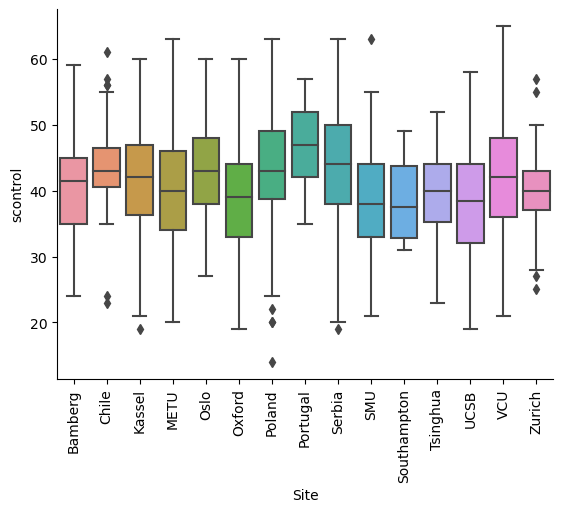

In [3]:
sns.boxplot(data=df_raw,
            x="Site",
            y="scontrol")

plt.xticks(rotation=90) 
sns.despine()
plt.show()

* 在当前层级模型的建立中，我们先使用其中5个站点的数据

In [4]:
# 选取5个站点
first5_site = ['Southampton','METU','Kassel','Tsinghua','Oslo']
df_first5 = df_raw.query("Site in @first5_site")

#为站点生成索引，为被试生成索引
df_first5["site_idx"] = pd.factorize(df_first5.Site)[0]
df_first5["obs_id"] = range(len(df_first5))

#设置索引，方便之后调用数据
df_first5.set_index(['Site','obs_id'],inplace=True,drop=False)


### 数据的层级结构

![Image Name](https://cdn.kesci.com/upload/s5eeyrh0s5.png?imageView2/0/w/960/h/960)


* $j$来表示站点，$j \in \{1,2, \ldots, 15\}$
* $i$来表示站点内部的每一个数据$i \in \{1,2,\ldots,n_j\}$
* 每一个被试的数据可以被表示为$Y_{ij}$，表示站点$j$内的第$i$个被试的自我控制分数观测值

$$
Y := \left((Y_{11}, Y_{21}, \ldots, Y_{n_1,1}), (Y_{12}, Y_{22}, \ldots, Y_{n_2,2}), \ldots, (Y_{1,15}, Y_{2,15}, \ldots, Y_{n_{15},15})\right)  .
$$


## 完全池化(Complete pooling)模型

* 在完全池化模型中，我们忽略个体的分组信息，认为这些个体直接来自一个更大的总体

![Image Name](https://cdn.kesci.com/upload/s5eflzcpoj.png?imageView2/0/w/960/h/960)

* 那么我们可以使用正态模型来建立complete pooled 模型：

$$
\begin{split}
Y_{ij} | \mu, \sigma & \sim N(\mu, \sigma^2) \\
\mu    & \sim N(0, 50^2) \\
\sigma & \sim \text{Exp}(1) \\
\end{split}
$$

**global parameters**

* $\mu$为自我控制分数在总体中的均值(global mean)

* $\sigma$为自我控制分数均值在总体中的标准差(global standard deviation)

**intercept-only regression model**

* 该模型和我们先前建立过的正态回归模型本质上是相同的，只不过我们尚未在该模型中引入自变量

* 因此当前模型可以被视为只包含截距项的正态回归模型


> 下图给出了所有552个被试自我控制分数的分布情况，分数范围大概在20-60之间

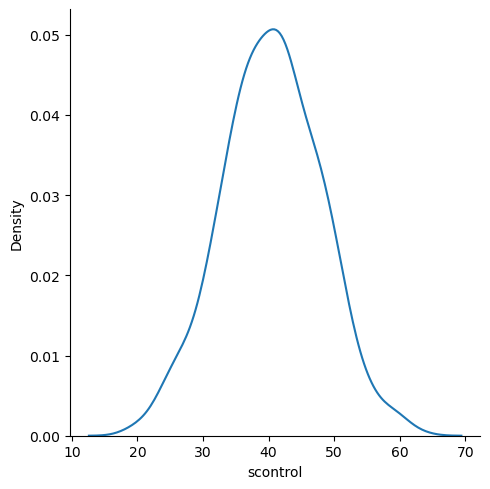

In [5]:
sns.displot(data=df_first5,
             x = "scontrol",
             kind="kde")

### 模型定义及MCMC采样

In [6]:
with pm.Model() as complete_pooled_model:

    mu = pm.Normal("mu", mu=0, sigma=50)          #定义beta_0          
    sigma = pm.Exponential("sigma", 1)                  #定义sigma

    likelihood = pm.Normal("y_est", mu=mu, sigma=sigma, observed=df_first5.scontrol)   #定义似然：预测值y符合N(mu, sigma)分布
                                                                                       #通过 observed 传入实际数据y 自我控制水平
    complete_trace = pm.sample(random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


### 查看后验参数估计

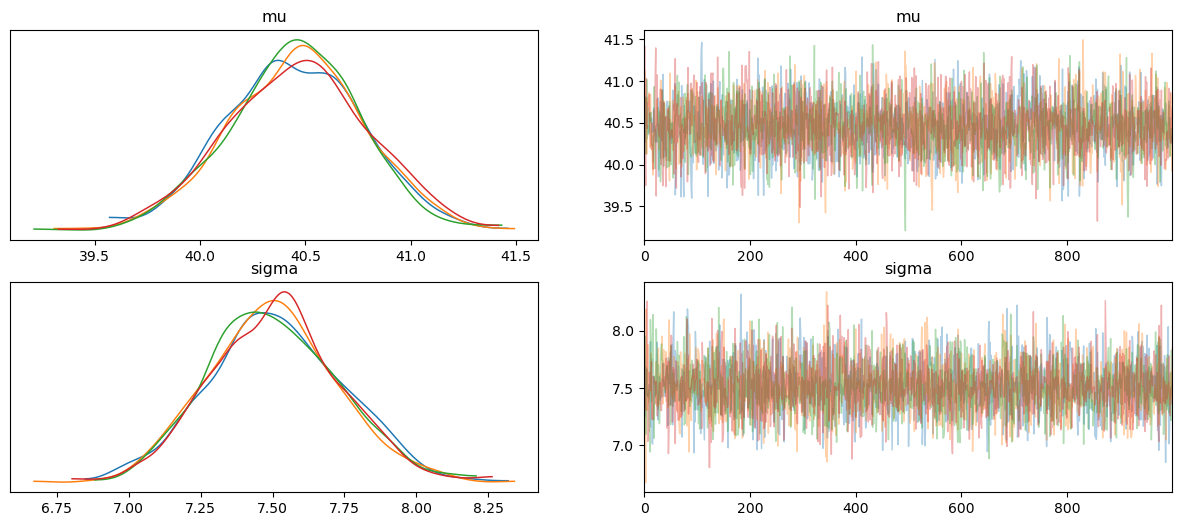

In [7]:
with complete_pooled_model:
    az.plot_trace(complete_trace,
                  compact=False,
                  figsize=(15,6))

In [8]:
az.summary(complete_trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     40.454  0.323  39.820   41.027      0.005    0.004    4129.0    2922.0   
sigma   7.509  0.229   7.102    7.955      0.003    0.002    4285.0    3023.0   

       r_hat  
mu       1.0  
sigma    1.0

### 后验预测分布

* 我们可以画出所有预测值的94%后验预测可信区间

* 同时可以观察真实值落在可信区间的情况

> (在lec11中，我们介绍过可信区间的绘制，主要借助`az.summary`生成后验预测总结的表格，并判断真实值是否落在可信区间内)

In [9]:
# 进行后验预测
complete_ppc = pm.sample_posterior_predictive(complete_trace,
                                              model=complete_pooled_model)

Sampling: [y_est]


In [10]:

def ppc_sum(ppc, data):
    
    hdi_sum = az.summary(ppc, hdi_prob=0.95)
    hdi_sum["obs_id"] = data["obs_id"].values
    hdi_sum["y"] = data["scontrol"].values
    hdi_sum["site"] = data["Site"].values

    return hdi_sum

In [11]:
complete_hdi_sum = ppc_sum(ppc = complete_ppc,
                data=df_first5)


In [142]:
from matplotlib.lines import Line2D

def ppc_plot(hdi_sum):
    fig, ax =  plt.subplots(figsize=(15,6))

    #生成站点条件
    c1 = hdi_sum["site"] == hdi_sum["site"].unique()[0]
    c2 = hdi_sum["site"] == hdi_sum["site"].unique()[1]
    c3 = hdi_sum["site"] == hdi_sum["site"].unique()[2]
    c4 = hdi_sum["site"] == hdi_sum["site"].unique()[3]
    c5 = hdi_sum["site"] == hdi_sum["site"].unique()[4]
    
    #根据站点选择不同的颜色（可信区间）
    colors = np.select([c1, c2, c3, c4, c5], 
                    ['orange', 'blue', 'green', 'purple','gray'])
    #绘制94%的可信区间
    HDI = ax.vlines(hdi_sum["obs_id"], 
            hdi_sum["hdi_2.5%"], hdi_sum["hdi_97.5%"], 
            color=colors, 
            alpha=0.5,
            label="94% HDI")
    #绘制后验预测均值
    pos_mean = ax.scatter(hdi_sum["obs_id"], hdi_sum["mean"],
                marker="_",
                c = 'black',
                alpha=0.2,
                zorder = 2,
                label="Posterior mean")
    #根据是否落在可信区间内选择不同的颜色
    colors = np.where((hdi_sum["y"] >= hdi_sum["hdi_2.5%"]) & (hdi_sum["y"] <= hdi_sum["hdi_97.5%"]), 
                    '#2F5597', '#C00000')
    #绘制真实值
    ax.scatter(hdi_sum["obs_id"], hdi_sum["y"],
            c = colors,
            alpha=0.7,
            zorder = 2)
#     #生成图例
#     legend_handles = [
#         Line2D([0], [0], color='red', label=hdi_sum["site"].unique()[0]),
#         Line2D([0], [0], color='blue', label=hdi_sum["site"].unique()[1]),
#         Line2D([0], [0], color='green', label=hdi_sum["site"].unique()[2]),
#         Line2D([0], [0], color='purple', label=hdi_sum["site"].unique()[3]),
#         Line2D([0], [0], color='gray', label=hdi_sum["site"].unique()[4])
#     ]

#     plt.legend(handles=legend_handles, 
#             loc='upper right',
#             bbox_to_anchor=(1.08, 1))
    
    count_per_site = hdi_sum.groupby("site").size().values

    # Calculate cumulative count and midpoint positions
    cumulative_count = count_per_site.cumsum()
    xtick = cumulative_count - count_per_site / 2
    plt.xticks(xtick,complete_hdi_sum["site"].unique())

    sns.despine()

* 横线部分表示每个观测值的后验预测均值

* 观察后验预测分布的结果可以发现，所有观测值的后验预测均值都是相似的

* 因为我们省略了分组信息，假测所有的观测值都来自同一正态分布

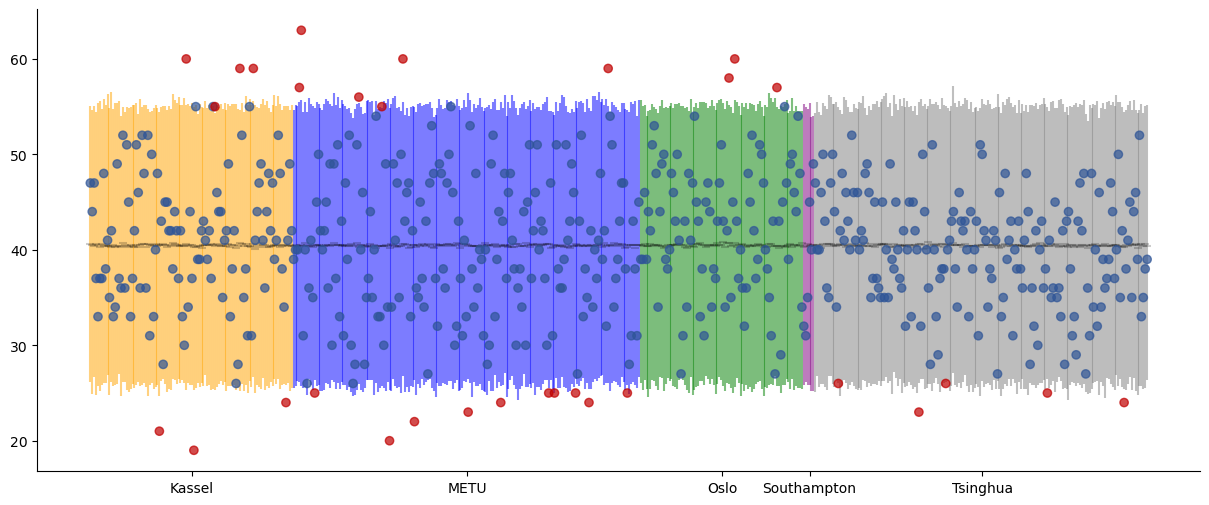

In [143]:
ppc_plot(hdi_sum=complete_hdi_sum)

## No pooling 非池化模型

* 在complete pooled模型中，我们忽略了数据来自不同的站点这一事实

* 现在我们考虑另外一种情况，我们假设五个站点分别来自不同的分布，对五个站点进行不同的分析

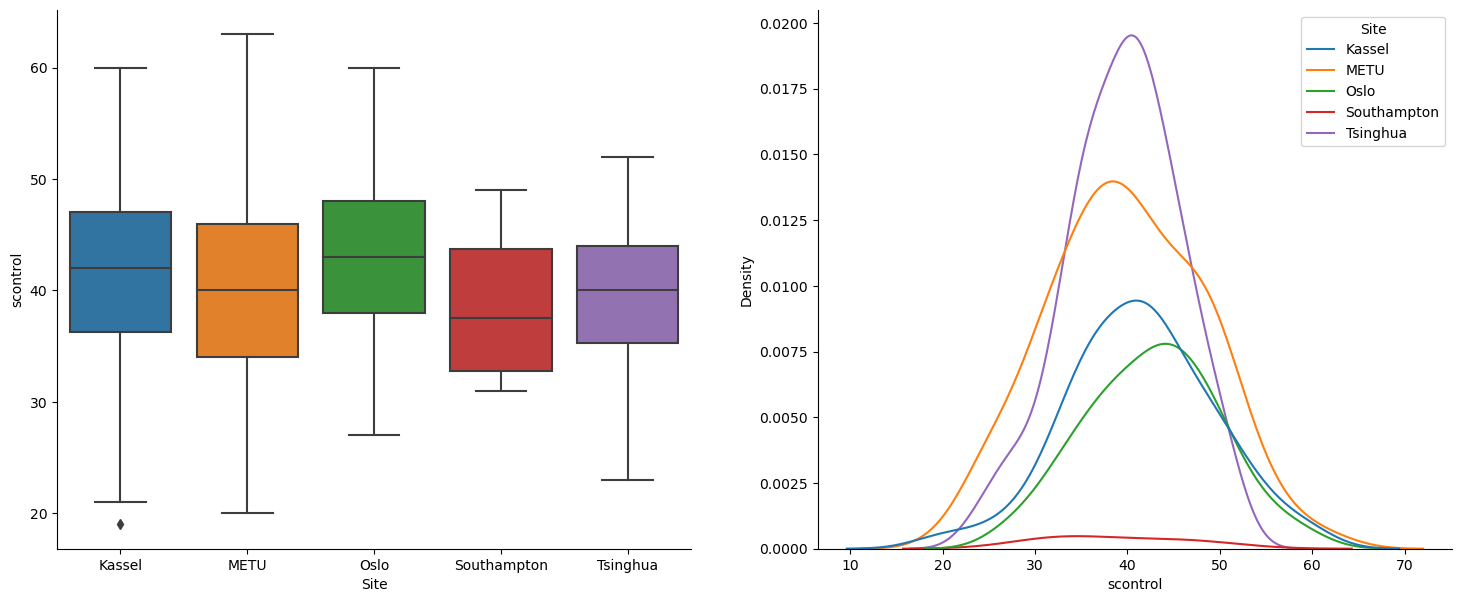

In [14]:
fig, ax = plt.subplots(1,2,figsize=(18,7))
sns.boxplot(data=df_first5,
            x="Site",
            y="scontrol",
            ax=ax[0])

sns.kdeplot(data=df_first5,
            x="scontrol",
            hue="Site",
             ax=ax[1])
sns.despine()

### Group-specific parameters

* 在完全池化模型中，我们使用了正态分布的参数来自总体层面；

* 在非池化模型中，我们认为正态分布的参数在组与组之间是不同的(group-specific)

![Image Name](https://cdn.kesci.com/upload/s5eh3sji4k.png?imageView2/0/w/960/h/960)

1. 使用$\mu_j$来表示每个站点的自我控制分数均值

    * 不同站点的$\mu_j$不同

    * 同一站点内的$\mu_j$是相同的

2. 那么，$\mu_j$从哪里来？我们可以从某个正态分布中抽出5个数值来作为 $\mu_j, \;\;j \in \{1,2, \ldots, 5\}$

3. 使用$\sigma_j$来表示每个站点内部自我控制分数的变异性

    * 和$\mu_j$类似，不同站点的$\sigma_j$不同，同一站点内的$\sigma_j$相同

**总结**

则对于站点$j$内的数据来说，自我控制分数满足：
$$
Y_{ij} | \mu_j, \sigma \sim N(\mu_j, \sigma_j^2) \\

\mu_j  \sim N(0, 50^2) \\

\sigma_j \sim \text{Exp}(1) \\
$$



### 模型定义及MCMC采样

In [15]:
coords = {"site": df_first5["Site"].unique(),
          "obs_id": df_first5.obs_id}

with pm.Model(coords=coords) as no_pooled_model:

    mu = pm.Normal("mu", mu=0, sigma=50, dims="site")          #定义mu，指定dims="site"，生成不同的mu         
    
    sigma = pm.Exponential("sigma", 2, dims="site")            #定义sigma，指定dims="site"，生成不同的sigma

    g = pm.MutableData("g", df_first5.site_idx, dims="obs_id") #获得观测值对应的站点缩影

    # Define likelihood
    likelihood = pm.Normal("y_est", mu=mu[g], sigma=sigma[g], observed=df_first5.scontrol, dims="obs_id")

    no_trace = pm.sample(random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


### 查看后验参数估计

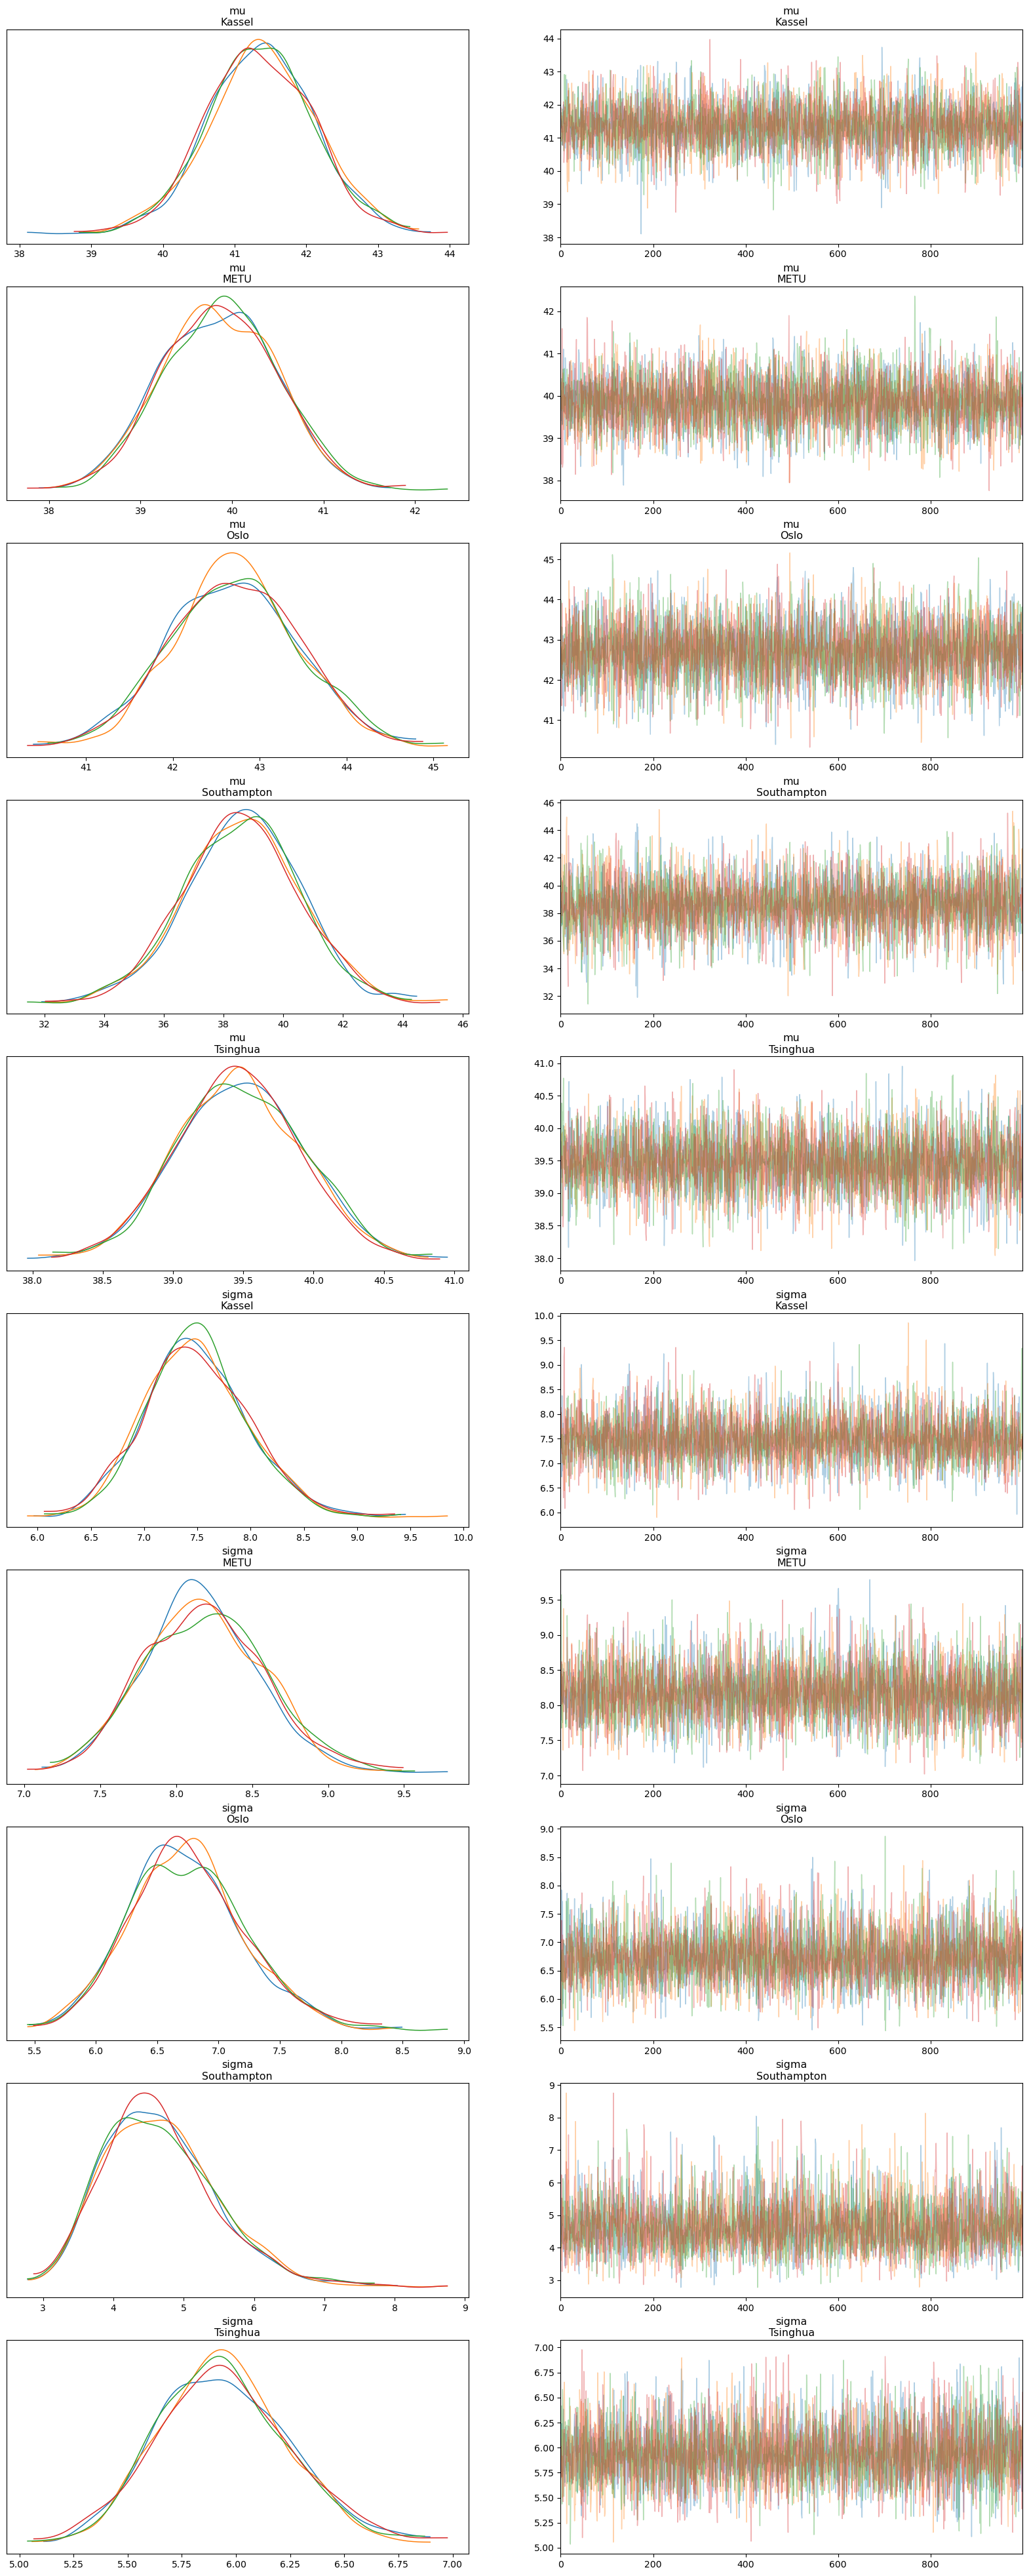

In [16]:
with no_pooled_model:
    az.plot_trace(no_trace,
                  compact=False,
                  figsize=(20,50))

In [58]:
no_trace.sel(site="METU")

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [57]:
no_trace.posterior.sel(site="METU")

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000)
Coordinates:
  * chain    (chain) int32 0 1 2 3
  * draw     (draw) int32 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
    site     <U11 'METU'
Data variables:
    mu       (chain, draw) float64 39.85 40.13 39.41 39.98 ... 39.08 39.82 40.03
    sigma    (chain, draw) float64 8.528 7.79 8.295 8.079 ... 8.793 8.33 8.041
Attributes:
    created_at:                 2023-12-10T12:22:40.557795
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.4.1
    sampling_time:              33.682523012161255
    tuning_steps:               1000

In [17]:
az.summary(no_trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
mu[Kassel]          41.358  0.738  39.991   42.810      0.010    0.007   
mu[METU]            39.862  0.620  38.717   41.010      0.008    0.006   
mu[Oslo]            42.711  0.729  41.361   44.085      0.009    0.007   
mu[Southampton]     38.610  1.935  34.969   42.275      0.027    0.019   
mu[Tsinghua]        39.470  0.447  38.624   40.284      0.006    0.004   
sigma[Kassel]        7.492  0.487   6.573    8.374      0.006    0.005   
sigma[METU]          8.183  0.398   7.468    8.953      0.005    0.004   
sigma[Oslo]          6.743  0.475   5.832    7.620      0.007    0.005   
sigma[Southampton]   4.667  0.818   3.258    6.202      0.012    0.009   
sigma[Tsinghua]      5.941  0.301   5.416    6.537      0.004    0.003   

                    ess_bulk  ess_tail  r_hat  
mu[Kassel]            5549.0    3164.0    1.0  
mu[METU]              5592.0    2960.0    1.0  
mu[Oslo]              6157.0    3004.0    1.0  
mu[Southampton]       5283.0    2963.0    1.0  
mu[Tsinghua]          5913.0    3192.0    1.0  
sigma[Kassel]         6101.0    2921.0    1.0  
sigma[METU]           5569.0    3232.0    1.0  
sigma[Oslo]           5463.0    2862.0    1.0  
sigma[Southampton]    4877.0    2939.0    1.0  
sigma[Tsinghua]       5319.0    2842.0    1.0

### 后验预测分布

In [18]:
no_ppc = pm.sample_posterior_predictive(no_trace,
                                        model=no_pooled_model)

Sampling: [y_est]


In [19]:
no_hdi_sum = ppc_sum(ppc = no_ppc,
                data=df_first5)

### 非池化模型的缺点

可以看到在非池化模型中，每个组的均值与方差都是不同的，非池化模型充分考虑了每个组内部的情况，然而，这种模型的缺点可能包括：

1. 在小样本数据上，非池化模型存在过拟合的风险(如Southampton)

2. 非池化模型假设每个组都属于不同的分布，因此其得出的结果难以用来预测新组别的情况

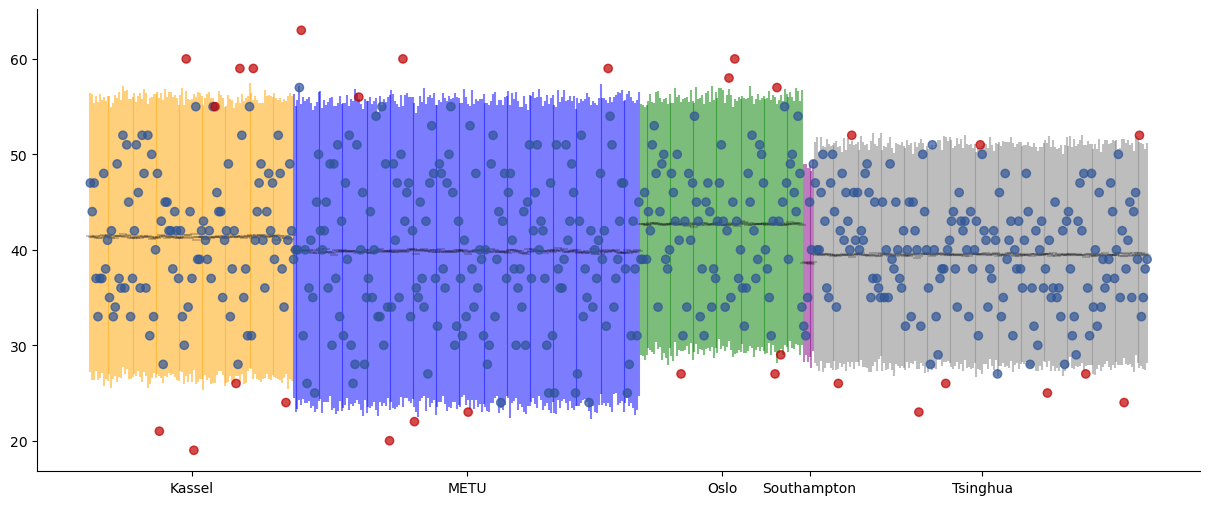

In [144]:
ppc_plot(hdi_sum=no_hdi_sum)

## Partial pooling

### 对层级模型的定义

* 现在，我们可以结合完全池化模型与非池化模型，完整地考虑数据结构

$$
\begin{array}{lrl}
\text{Layer 1:} \hspace{0.5in} Y_{ij} | \mu_j, \sigma_y \sim N(\mu_j, \sigma_y^2) \hspace{0.05in} \text{自我控制分数在组内的变异性}\\

\text{Layer 2:} \hspace{0.5in} \mu_j | \mu, \sigma_\mu \stackrel{ind}{\sim} N(\mu, \sigma_\mu^2) \hspace{0.13in} \text{均值在组间的变异性}\\

\text{Layer 3:}  \hspace{0.5in}\mu,\sigma_y,\sigma_\mu \hspace{0.85in}{超参数}\\
\hspace{1in}\mu \sim N(40, 20^2) \\
\hspace{1in}\sigma_y \sim \text{Exp}(1)\\
\hspace{1in} \sigma_\mu \sim \text{Exp}(1)\\
\end{array}
$$

![Image Name](https://cdn.kesci.com/upload/s5enwlkkz8.png?imageView2/0/w/960/h/960)

1. 在最上层：

    * 使用$\mu$来表示总体的$Y$(global average)，即总体而言，自我控制分数的均值

    * 使用$\sigma_\mu$来表示组与组之间在$Y$均值上的变异性

    * 使用$\sigma_y$来表示每个组内部$Y$的变异性(这里我们假设每个组内部的变异性相同)

2. 在第二层：
    * 使用$\mu_j$来表示每个组$Y$的均值，而$\mu_j$服从$N(\mu, \sigma_\mu^2)$，这两个参数是从上一层得到的

3. 在第三层：
    * 使用$Y_{ij}$来表示组内每个个体的$Y$，而$Y_{ij}$服从$N(\mu_j, \sigma_y^2)$，这两个参数是从上一层得到的


### 另一种定义方式

* 我们也可以这样来理解层级模型：

    * $\mu_j$表示：每个站点的自我控制均分

    * $\sigma_\mu$表示：$\mu_j$偏离总体自我控制均分$\mu$的程度

* 那么，$\mu_j$与$\mu$的关系式可以写为：

$$\mu_j = \mu + b_{j}$$  

* 同时，$b_j$满足
$$b_j \sim N(0, \sigma_\mu^2)$$

* 那么层级模型的Layer1 和 Layer2也可以写为：

$$
\begin{split}
Y_{ij} | \mu_j, \sigma_y & \sim N(\mu_j, \sigma_y^2) \;\; \text{ with } \;\; \mu_j = \mu + b_{j}  \\
b_{j} | \sigma_\mu    & \stackrel{ind}{\sim} N(0, \sigma_\mu^2) \\
\mu           & \sim N(40, 20^2) \\
\sigma_y      & \sim \text{Exp}(1) \\
\sigma_\mu    & \sim \text{Exp}(1) \\
\end{split}
$$

### 模型定义及MCMC采样

In [21]:
with pm.Model(coords=coords) as partial_pooled_model:
    # Hyperpriors
    var_y = pm.Exponential("within_variability", 1)
    var_mu = pm.Exponential("between_variability", 1)
    hyper_mu = pm.Normal("hyper_mu", mu=40, sigma=20)
    
    mu = pm.Normal("mu", mu=hyper_mu, sigma=var_mu, dims="site")

    g = pm.MutableData("g", df_first5.site_idx, dims="obs_id")

    likelihood = pm.Normal("y_est", mu=mu[g], sigma=var_y, observed=df_first5.scontrol, dims="obs_id")

    partial_trace = pm.sample(random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [within_variability, between_variability, hyper_mu, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.
There were 105 divergences after tuning. Increase `target_accept` or reparameterize.


In [162]:
new_group = df_raw[df_raw.Site=="Zurich"]

new_group["obs_id"] = range(len(new_group))

new_group["site_idx"] = pd.factorize(new_group.Site)[0]

In [164]:
new_coords = {"site": new_group["Site"].unique(),
          "obs_id": new_group.obs_id}

with pm.Model(coords=new_coords) as partial_pooled_pred:
    # Hyperpriors
    var_y = pm.Exponential("within_variability", 1)
    var_mu = pm.Exponential("between_variability", 1)
    hyper_mu = pm.Normal("hyper_mu", mu=40, sigma=20)
    
    new_mu = pm.Normal("new_mu", mu=hyper_mu, sigma=var_mu, dims="site")

    g = pm.MutableData("g", new_group.site_idx, dims="obs_id")

    likelihood = pm.Normal("y_est", mu=new_mu[g], sigma=var_y, observed=new_group.scontrol, dims="obs_id")

    pred_trace = pm.sample_posterior_predictive(partial_trace,
                                                var_names=["y_est"],
                                                predictions=True,
                                                extend_inferencedata=True,
                                                random_seed=84735)

Sampling: [new_mu, y_est]


In [165]:
pred_trace

Inference data with groups:
	> posterior
	> predictions
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data

In [22]:
with pm.Model(coords=coords) as partial_pooled_model_2:
    # Hyperpriors
    var_y = pm.Exponential("within_variability", 1)
    var_mu = pm.Exponential("between_variability", 1)
    hyper_mu = pm.Normal("hyper_mu", mu=40, sigma=20)
    mu_j = pm.Normal("mu_j", mu=0, sigma=var_mu, dims="site")
    mu = pm.Deterministic("mu", mu_j + hyper_mu)

    g = pm.MutableData("g", df_first5.site_idx, dims="obs_id")

    likelihood = pm.Normal("y_est", mu=mu[g], sigma=var_y, observed=df_first5.scontrol, dims="obs_id")

### 查看后验参数估计

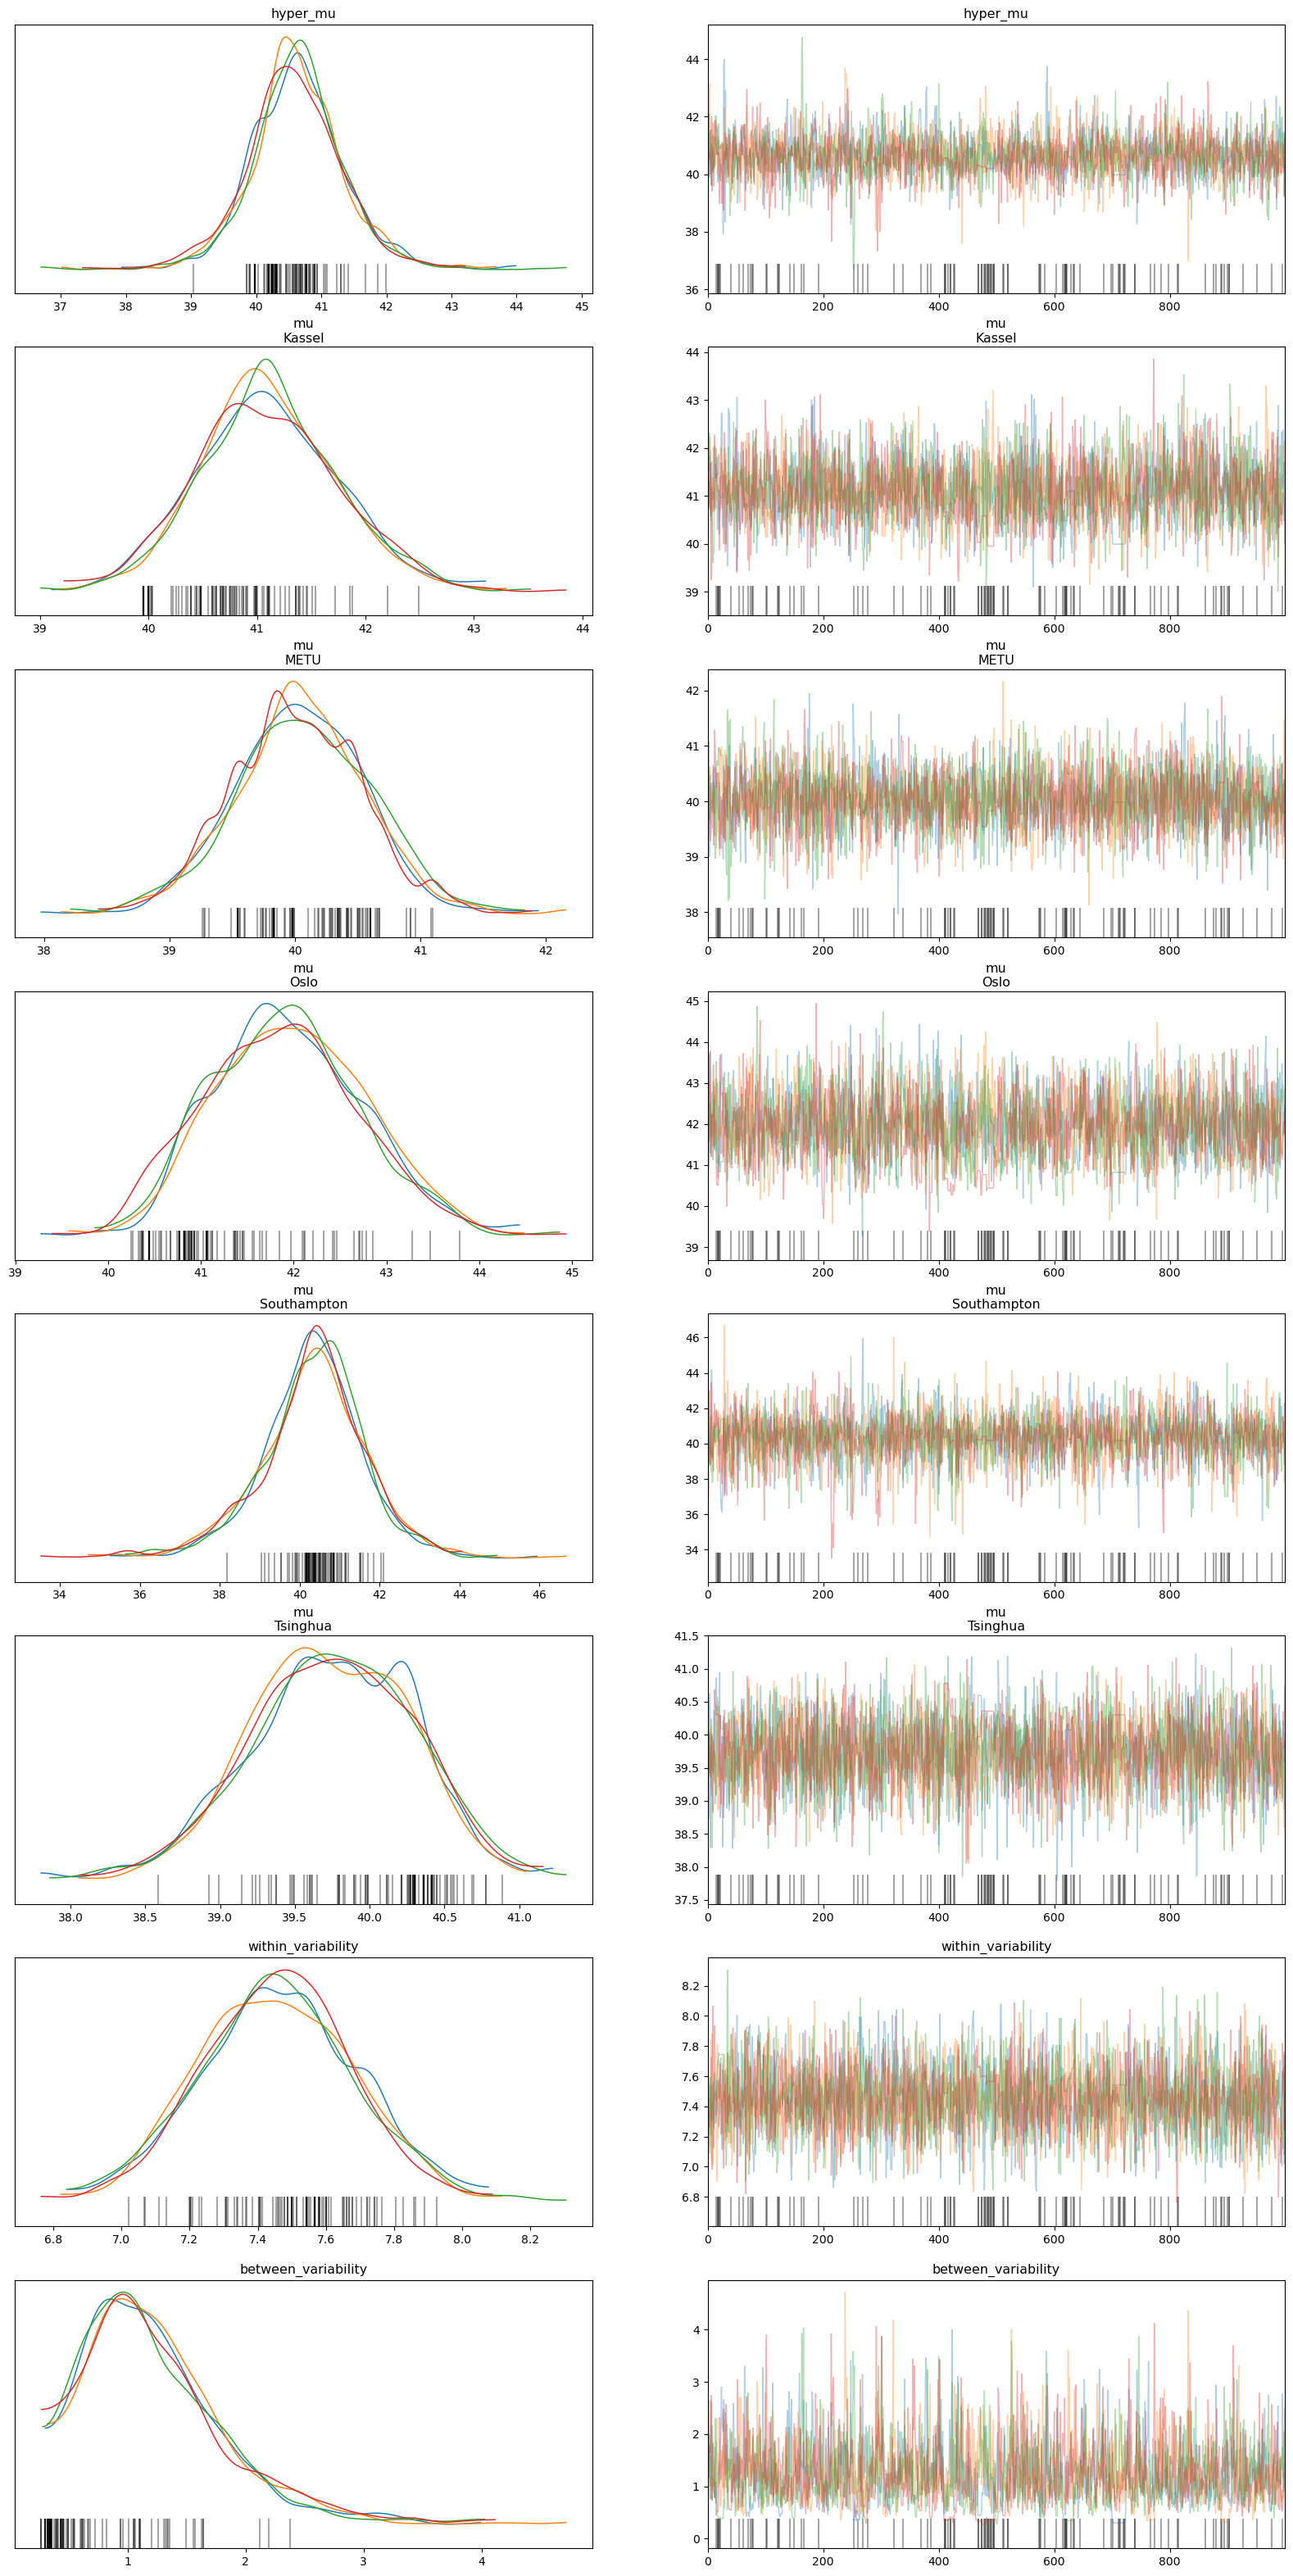

In [23]:
with partial_pooled_model:
    az.plot_trace(partial_trace,
                  compact=False,
                  figsize=(20,40))

In [24]:
az.summary(partial_trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
hyper_mu             40.621  0.728  39.330   42.098      0.015    0.010   
mu[Kassel]           41.101  0.645  39.950   42.381      0.016    0.011   
mu[METU]             40.039  0.525  39.012   40.981      0.009    0.006   
mu[Oslo]             41.925  0.802  40.432   43.378      0.023    0.016   
mu[Southampton]      40.324  1.329  37.615   42.753      0.025    0.018   
mu[Tsinghua]         39.747  0.535  38.737   40.699      0.012    0.008   
within_variability    7.457  0.225   7.043    7.890      0.004    0.003   
between_variability   1.231  0.608   0.297    2.306      0.018    0.013   

                     ess_bulk  ess_tail  r_hat  
hyper_mu               2419.0    2645.0    1.0  
mu[Kassel]             1658.0     891.0    1.0  
mu[METU]               3306.0    2520.0    1.0  
mu[Oslo]               1119.0     297.0    1.0  
mu[Southampton]        3092.0    2360.0    1.0  
mu[Tsinghua]           2057.0    1949.0    1.0  
within_variability     2872.0    2644.0    1.0  
between_variability     701.0     286.0    1.0

## Within- vs between-group variability

* 在完全池化模型中，变异性的来源只有一种，即个体观测值$Y$在总体中的变异，

* 但现在我们可以把个体观测值$Y$的变异来源分解成两个部分：

    * 组内变异 $\sigma_y^2$
    * 组间变异 $\sigma_{\mu}^2$
$$
\text{Var}(Y_{ij}) = \sigma_y^2 + \sigma_{\mu}^2 
$$

* 这是我们熟悉的单因素方差分析

![Image Name](https://cdn.kesci.com/upload/s5eppwep1v.png?imageView2/0/w/960/h/960)

$$
\begin{split}
\frac{\sigma^2_y}{\sigma^2_\mu + \sigma^2_y} 
& = \text{ $\text{Var}(Y_{ij})$ 可以被组内方差解释的部分} \\
\frac{\sigma^2_\mu}{\sigma^2_\mu + \sigma^2_y} 
& = \text{$\text{Var}(Y_{ij})$ 可以被组间方差解释的部分} \\
\end{split}
$$


* 组间方差远大于组内方差($\sigma_\mu > \sigma_y$)，那么组间方差可以解释大部分观测值的变异
* 组间方差远小于组内方差($\sigma_\mu < \sigma_y$)，那么组与组之间的区别就不是很明显


* 此外，若组间方差远大于组内方差，则可以说明组内的变异性很小，组内分数高度相关

$$
\text{Cor}(Y_{ij}, Y_{kj}) = \frac{\sigma^2_\mu}{\sigma^2_\mu + \sigma^2_y} 
$$

* 下图展示了三种组间方差与组内方差的分布情况(横轴为方差)
![Image Name](https://cdn.kesci.com/upload/s5equxkezx.png?imageView2/0/w/960/h/960)

* 使用`az.summary`来总结后验参数估计的情况，并进行计算

In [25]:
partial_para_sum = az.summary(partial_trace).reset_index()
between_sd = partial_para_sum[partial_para_sum["index"] == "between_variability"]["mean"].values
within_sd = partial_para_sum[partial_para_sum["index"] == "within_variability"]["mean"].values
var = between_sd**2 + within_sd**2
print("被组间方差所解释的部分：", between_sd**2/var)
print("被组内方差所解释的部分：", within_sd**2/var)
print("组内相关：",between_sd**2/var)

被组间方差所解释的部分： [0.0265284]
被组内方差所解释的部分： [0.9734716]
组内相关： [0.0265284]


In [26]:
partial_ppc = pm.sample_posterior_predictive(partial_trace,
                                            model=partial_pooled_model)

Sampling: [y_est]


### 后验预测分布

* 可以看到相比于非池化模型，在层级模型中不同组的后验预测可信区间的长度、后验预测均值都更为接近，

In [27]:
partial_hdi_sum = ppc_sum(ppc=partial_ppc,
                  data=df_first5)

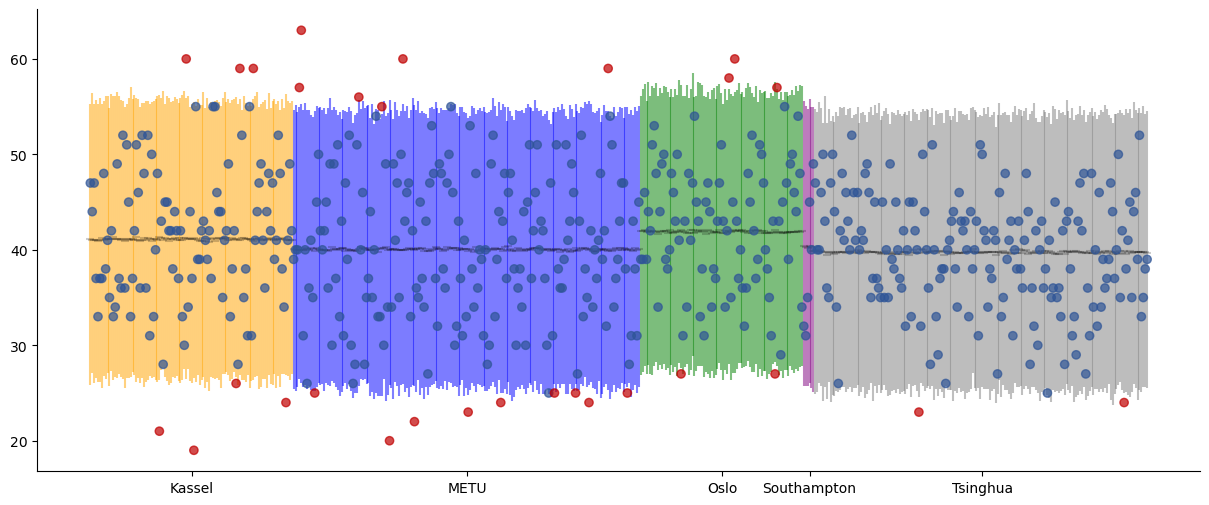

In [145]:
ppc_plot(hdi_sum=partial_hdi_sum)

## Shrinkage & the bias-variance trade-off

* 在完全池化模型中，对于每一个站点来说，后验估计均值都是相同的，在弱先验的情况下，后验估计均值约等于所有观测值的平均值
$$
\overline{y}_{\text{global}} = \frac{1}{n}\sum_{\text{all } i,j }y_{ij}
$$

* 在非池化模型中，对于每一个站点来说，其后验估计均值的估计只来自该组内部，在弱先验的情况下，后验估计均值约等于该组内所有观测值的平均值
$$
\overline{y}_j = \frac{1}{n_j}\sum_{i=1}^{n_j} y_{ij}
$$

* 在层级模型中，后验估计均值则是在完全池化和非池化模型中找到一个平衡，组间(group-specific)参数有可能更倾向完全池化模型，也有可能更倾向于非池化模型，这种现象被称为shrinkage

$$
\frac{\sigma^2_y}{\sigma^2_y + n_j \sigma^2_\mu} \overline{y}_{\text{global}} + \frac{n_j\sigma^2_\mu}{\sigma^2_y + n_j \sigma^2_\mu} \overline{y}_j
$$

(待补)

In [104]:
complete_hdi_sum

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
y_est[0]    40.594  7.478    26.150     55.062      0.119    0.085    3926.0   
y_est[1]    40.507  7.564    24.899     54.654      0.121    0.086    3887.0   
y_est[2]    40.389  7.320    26.682     55.085      0.117    0.083    3892.0   
y_est[3]    40.580  7.578    24.743     54.388      0.127    0.091    3556.0   
y_est[4]    40.475  7.629    25.694     55.399      0.121    0.086    3967.0   
...            ...    ...       ...        ...        ...      ...       ...   
y_est[547]  40.520  7.524    25.769     54.664      0.120    0.085    3926.0   
y_est[548]  40.588  7.566    25.759     55.227      0.120    0.085    4012.0   
y_est[549]  40.393  7.457    25.385     54.348      0.117    0.083    4061.0   
y_est[550]  40.605  7.562    25.550     55.105      0.118    0.083    4133.0   
y_est[551]  40.403  7.508    26.404     55.169      0.119    0.084    3970.0   

            ess_tail  r_hat  obs_id   y      site  
y_est[0]      3738.0    1.0       0  47    Kassel  
y_est[1]      3908.0    1.0       1  44    Kassel  
y_est[2]      3930.0    1.0       2  47    Kassel  
y_est[3]      3548.0    1.0       3  37    Kassel  
y_est[4]      3845.0    1.0       4  33    Kassel  
...              ...    ...     ...  ..       ...  
y_est[547]    3851.0    1.0     547  52  Tsinghua  
y_est[548]    3733.0    1.0     548  33  Tsinghua  
y_est[549]    4043.0    1.0     549  35  Tsinghua  
y_est[550]    4095.0    1.0     550  38  Tsinghua  
y_est[551]    3972.0    1.0     551  39  Tsinghua  

[552 rows x 12 columns]

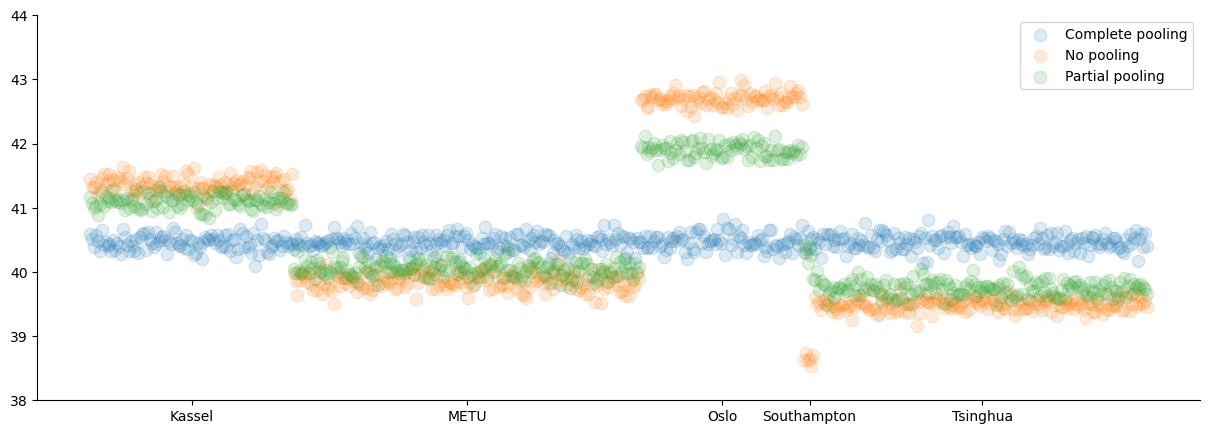

In [154]:
plt.figure(figsize=(15,5))

plt.scatter(complete_hdi_sum["obs_id"],
            complete_hdi_sum["mean"],
            alpha=0.15,
            s=80,
            label="Complete pooling")
plt.scatter(no_hdi_sum["obs_id"],
            no_hdi_sum["mean"],
            alpha=0.15,
            s=80,
            label="No pooling")
plt.scatter(partial_hdi_sum["obs_id"],
            partial_hdi_sum["mean"],
            alpha=0.15,
            s=80,
            label="Partial pooling")

plt.ylim(38,44)

plt.legend()

count_per_site = df_first5.groupby(level="Site").size().values

cumulative_count = count_per_site.cumsum()
xtick = cumulative_count - count_per_site / 2
plt.xticks(xtick,df_first5["Site"].unique())

sns.despine()

## bambi code

In [29]:
complete_model = bmb.Model("scontrol ~ 1", df_first5,
                           family="gaussian")
complete_idata = complete_model.fit(random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [scontrol_sigma, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


In [30]:
az.summary(complete_idata)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept       40.451  0.324  39.888   41.076      0.005    0.004    3546.0   
scontrol_sigma   7.557  0.223   7.097    7.933      0.004    0.002    4044.0   

                ess_tail  r_hat  
Intercept         2746.0    1.0  
scontrol_sigma    2971.0    1.0

In [31]:
no_model = bmb.Model("scontrol ~ 0 + C(Site)", df_first5,
                     categorical="Site")
no_idata = no_model.fit(random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [scontrol_sigma, C(Site)]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.


In [32]:
az.summary(no_idata)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
C(Site)[Kassel]       41.310  0.745  39.994   42.762      0.009    0.006   
C(Site)[METU]         39.846  0.555  38.805   40.892      0.007    0.005   
C(Site)[Oslo]         42.678  0.791  41.127   44.081      0.010    0.007   
C(Site)[Southampton]  38.654  3.025  32.857   44.358      0.038    0.027   
C(Site)[Tsinghua]     39.464  0.545  38.451   40.465      0.007    0.005   
scontrol_sigma         7.485  0.229   7.067    7.919      0.003    0.002   

                      ess_bulk  ess_tail  r_hat  
C(Site)[Kassel]         6910.0    2990.0    1.0  
C(Site)[METU]           5787.0    3084.0    1.0  
C(Site)[Oslo]           6874.0    3339.0    1.0  
C(Site)[Southampton]    6249.0    3288.0    1.0  
C(Site)[Tsinghua]       6301.0    3418.0    1.0  
scontrol_sigma          5709.0    3180.0    1.0

In [33]:
partial_model = bmb.Model("scontrol ~ 1 + (1|Site)", df_first5,
                     categorical="Site")
partial_idata = partial_model.fit(random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [scontrol_sigma, Intercept, 1|Site_sigma, 1|Site_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.


In [34]:
az.summary(partial_idata)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept            40.733  1.070  38.621   42.615      0.133    0.097   
scontrol_sigma        7.481  0.232   7.024    7.890      0.006    0.004   
1|Site_sigma          1.921  1.241   0.027    4.270      0.087    0.069   
1|Site[Kassel]        0.451  1.169  -1.778    2.631      0.116    0.082   
1|Site[METU]         -0.751  1.162  -3.016    1.341      0.150    0.146   
1|Site[Oslo]          1.430  1.216  -0.541    3.845      0.097    0.069   
1|Site[Southampton]  -0.572  1.681  -4.199    2.269      0.072    0.054   
1|Site[Tsinghua]     -1.067  1.143  -3.352    0.915      0.128    0.136   

                     ess_bulk  ess_tail  r_hat  
Intercept               165.0      43.0   1.03  
scontrol_sigma         1704.0    1435.0   1.00  
1|Site_sigma            328.0     216.0   1.01  
1|Site[Kassel]          186.0      48.0   1.02  
1|Site[METU]            120.0      41.0   1.03  
1|Site[Oslo]            230.0      54.0   1.02  
1|Site[Southampton]     621.0     400.0   1.01  
1|Site[Tsinghua]        203.0      50.0   1.03